In [1]:
import importlib
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
from multi_loc import covariance, assimilate

In [3]:
%matplotlib inline

In [4]:
def imshow(X, title=None, vmin=None, vmax=None, cmap=None):
    plt.figure()
    im = plt.imshow(X, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im)
    plt.title(title)

In [17]:
dimension = 2**9
print(dimension)
rho0 = 0.1
# dx = 0.25
dx = 1/dimension

obs_size = int(dimension/2)
H = assimilate.random_H(dimension, obs_size)

# H = np.eye(dimension)[::2]
obs_size = H.shape[0]

rho = np.arange(dimension, dtype=float)
rho = np.minimum(rho, (dimension - rho) % dimension)
rho = rho*dx

512


In [18]:
eig_val, eig_vec, P, sort_ind = covariance.generate_circulant(
    dimension, dx, rho0, covariance.fft_sqd_exp_1d,
    return_Corr=True,
    return_sort_ind=True)
eig_val = eig_val * (eig_val.size/eig_val.sum())
eig_vec = eig_vec.real + eig_vec.imag
# sort_ind = np.argsort(sort_ind)
# eig_val = eig_val[sort_ind]
# eig_vec = eig_vec[:, sort_ind]
# eig_val = np.fft.fftshift(eig_val)
# eig_vec = np.fft.fftshift(eig_vec, axes=1)

P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
P = P.real

R = np.eye(obs_size)

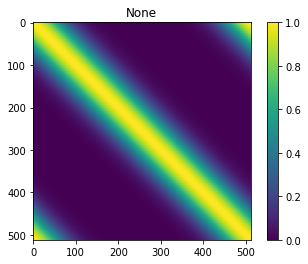

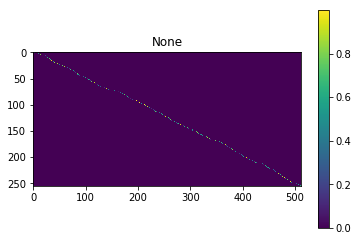

In [19]:
imshow(P, vmin=0)
imshow(H)

In [20]:
trans_mats = assimilate.transformation_matrices(
    H, eig_val_p=eig_val, eig_vec_p=eig_vec,
    R=R, return_Ts=True)

for key, val in trans_mats.items():
    exec(key + '=val')

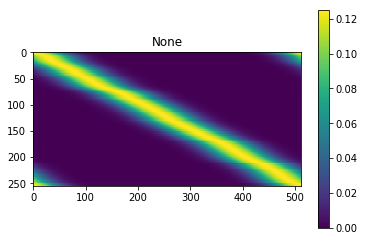

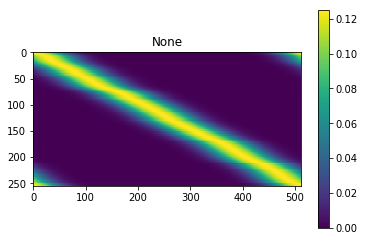

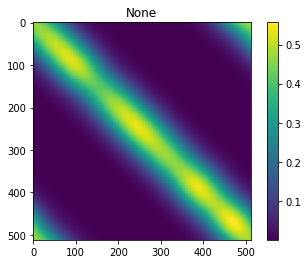

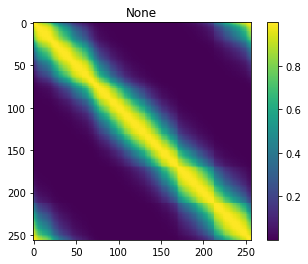

In [21]:
imshow(U @ S @ VT)
imshow(H @ P_sqrt)

imshow((H @ P_sqrt).T @ (H @ P_sqrt))

imshow((H @ P_sqrt) @ (H @ P_sqrt).T)

In [157]:
ens_ens_size = 4
ens_size = 40
sig_num = 1
mu = np.zeros(dimension)
ensemble_array = np.ones(
    [dimension, ens_size, ens_ens_size,
    ]) * np.nan
for t_num in range(ens_ens_size):
    ensemble_array[:, :, t_num] = (
        assimilate.generate_ensemble(
            ens_size, mu, trans_mats['P_sqrt']))

In [158]:
P_sample_array = np.zeros([dimension, dimension, ens_ens_size])
for i in range(ens_ens_size):
    P_sample_array[:, :, i] = np.cov(ensemble_array[:, :, i])

In [159]:
# imshow(reduced_true, f'Reduced true; sig_num: {sig_num}')

# rho_array = np.linspace(.31, 0.005, 40)
rho_array = np.linspace(0.5, 0.01, 40)
# rho_array = np.linspace(.31, 0.005, 2)

s_array = np.ones([sig_num, rho_array.size, ens_ens_size]) * np.nan
U_array = np.ones([obs_size, sig_num, rho_array.size, ens_ens_size]) * np.nan
V_array = np.ones([dimension, sig_num, rho_array.size, ens_ens_size]) * np.nan

# ##
# P_var = np.ones([dimension, dimension, rho_array.size])
# P_sqrt_var = np.ones([dimension, dimension, rho_array.size])
# ##
for rho_count, rho_loc in enumerate(rho_array):
    [loc] = covariance.generate_circulant(
        dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
        return_Corr=True, return_eig=False)
    loc /= loc.max()
    for ens_count in range(ens_ens_size):
        P_loc = P_sample_array[:, :, ens_count] * loc
    #     imshow(P_loc, f'P_loc: {rho_loc:0.3}')
        
        this_trans_mats = assimilate.transformation_matrices(
            H, P=P_loc,
            R=R, return_Ts=True)
        aU = this_trans_mats['U']
        aS = this_trans_mats['S']
        aVT = this_trans_mats['VT']
        s_array[:sig_num, rho_count, ens_count] = aS.diagonal()[:sig_num]
        U_array[:, :sig_num, rho_count, ens_count] = aU[:, :sig_num]
        V_array[:, :sig_num, rho_count, ens_count] = aVT[:sig_num, :].T
#         ##
#         P_array[:, :, ens_count] = P_loc
#         P_sqrt_array[:, :, ens_count] = this_trans_mats['P_sqrt']
#         ##
    
#     ##
#     P_var[:, :, count] = np.var(
#         P_array, axis=-1)
#     P_sqrt_var[:, :, count] = np.var(
#         P_sqrt_array, axis=-1)
#     ##   

In [160]:
reduced_true = U[:, :sig_num] @ S[:sig_num, :sig_num] @ VT[:sig_num]
# imshow(reduced_true, f'Reduced true; sig_num: {sig_num}')

error_n2 = np.ones([rho_array.size]) * np.nan
exp_error_n2 = np.ones([rho_array.size]) * np.nan
reduced_mean = np.ones([obs_size, dimension, rho_array.size]) * np.nan
reduced_var = np.ones([obs_size, dimension, rho_array.size]) * np.nan
mse = np.ones([obs_size, dimension, rho_array.size]) * np.nan

comb_num = round(
    math.factorial(ens_ens_size)
    / (math.factorial(2) 
       * math.factorial(ens_ens_size - 2)))

for rho_count, rho_loc in enumerate(rho_array):
    reduced_array = np.ones([obs_size,
                             dimension,
                             ens_ens_size]) * np.nan
    ens_diff_n2 = np.ones(comb_num) * np.nan
    ens_diff_count = 0
    for ens_count in range(ens_ens_size):
        aU = U_array[:, :sig_num, rho_count, ens_count]
        aS = s_array[:sig_num, rho_count, ens_count]
        aS = np.diag(aS)
        aVT = V_array[:, :sig_num, rho_count, ens_count].T
        
        reduced_array[:, :, ens_count] = (
            aU[:, :sig_num]
            @ aS[:sig_num, :sig_num]
            @ aVT[:sig_num])
        for other_ens_count in range(ens_count + 1, ens_ens_size):
            aU = U_array[:, :sig_num, rho_count, other_ens_count]
            aS = s_array[:sig_num, rho_count, other_ens_count]
            aS = np.diag(aS)
            aVT = V_array[:, :sig_num, rho_count, other_ens_count].T
            other_reduced_array = (
                aU[:, :sig_num]
                @ aS[:sig_num, :sig_num]
                @ aVT[:sig_num])
            ens_diff_n2[ens_diff_count] = sp.linalg.norm(
                reduced_array[:, :, ens_count] - other_reduced_array)
            ens_diff_count += 1
    
    reduced_mean[:, :, rho_count] = np.mean(
        reduced_array, axis=-1)
    reduced_var[:, :, rho_count] = np.var(
        reduced_array, axis=-1)
    mse[:, :, rho_count] = (
        (reduced_array - reduced_true[:, :, None])**2).mean(axis=-1)
    
#     temp_err = reduced_array - reduced_mean[:, :, rho_count][:, :, None]
#     exp_error_n2[rho_count] = sp.linalg.norm(temp_err, ord=2, axis=(0, 1)).mean()
    exp_error_n2[rho_count] = ens_diff_n2.mean()
    
#     error_n2[rho_count] = sp.linalg.norm(
#         reduced_mean[:, :, rho_count] - reduced_true,
#         ord=2)
    
    error_n2[rho_count] = sp.linalg.norm(
        reduced_array - reduced_true[:, :, None],
        ord=2, axis=(0, 1)).mean()
    

In [161]:
def angle(V0, V1):
    IPs = V0.T @ V1
    norm0 = (V0 ** 2).sum(axis=0)
    norm1 = (V1 ** 2).sum(axis=0)
    norm0 = norm0[:, None]
    norm1 = norm1[None, :]
    sigmas = sp.linalg.svd(
        IPs / np.sqrt(norm0 * norm1),
        compute_uv=False)
    dist = np.arccos(sigmas.min())
    return dist


def angle_2(V0, V1):
    norm0 = sp.linalg.norm(V0, ord=2, axis=0)
    norm1 = sp.linalg.norm(V1, ord=2, axis=0)
    V0 = V0/norm0
    V1 = V1/norm1
    IPs = V0.T @ V1
    sigmas = sp.linalg.svd(
        IPs,
        compute_uv=False)
    dist = np.arccos(sigmas)
    dist = dist.mean()
    return dist

In [162]:
import math
true_V = VT[:sig_num].T
sample_mean_V = V_array.mean(axis=-1)
V_angle_truth2ens = np.ones(
    [1, rho_array.size, ens_ens_size]) * np.nan

comb_num = round(
    math.factorial(ens_ens_size)
    / (math.factorial(2) 
       * math.factorial(ens_ens_size - 2)))
V_average_angle = np.ones(
    rho_array.size) * np.nan
V_variance_angle = V_average_angle.copy()
for rho_count in range(rho_array.size):
    angle_count = 0
    angles = np.ones(comb_num) * np.nan
    for ens_count in range(ens_ens_size):
        aV = V_array[:, :, rho_count, ens_count]
        V_dist = angle_2(aV, true_V)
        V_angle_truth2ens[0, rho_count, ens_count] = V_dist
        for other_ens_count in range(ens_count + 1, ens_ens_size):
            oV = V_array[:, :, rho_count, other_ens_count]
            V_dist = angle_2(aV, oV)
            angles[angle_count] = V_dist
            angle_count += 1
    V_average_angle[rho_count] = angles.mean()
    V_variance_angle[rho_count] = angles.var()
V_angle_truth2ens_var = V_angle_truth2ens.var(axis=-1)
V_angle_truth2ens_mean = V_angle_truth2ens.mean(axis=-1)

Text(0.5,1,'Variance of angles')

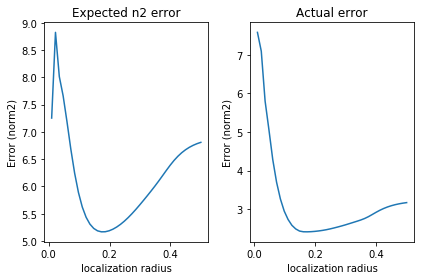

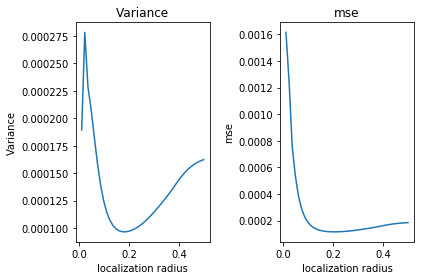

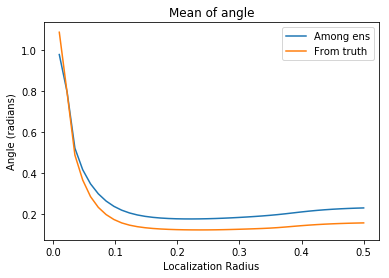

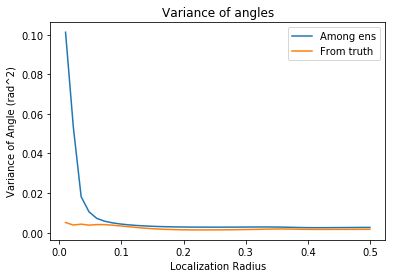

In [77]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(rho_array, exp_error_n2)
ax[0].set_title('Expected n2 error')
ax[0].set_ylabel('Error (norm2)')
ax[0].set_xlabel('localization radius')

ax[1].plot(rho_array, error_n2)
ax[1].set_title('Actual error')
ax[1].set_ylabel('Error (norm2)')
ax[1].set_xlabel('localization radius')
fig.tight_layout()

fig, ax = plt.subplots(1, 2)
ax[0].plot(rho_array, reduced_var.mean(axis=(0, 1)))
ax[0].set_title('Variance')
ax[0].set_ylabel('Variance')
ax[0].set_xlabel('localization radius')

ax[1].plot(rho_array, mse.mean(axis=(0, 1)))
ax[1].set_title('mse')
ax[1].set_ylabel('mse')
ax[1].set_xlabel('localization radius')
fig.tight_layout()

plt.figure()
plt.plot(rho_array, V_average_angle)
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.legend(['Among ens', 'From truth'])
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle')


plt.figure()
plt.plot(rho_array, V_variance_angle)
plt.plot(rho_array, V_angle_truth2ens_var.ravel())
plt.legend(['Among ens', 'From truth'])
plt.xlabel('Localization Radius')
plt.ylabel('Variance of Angle (rad^2)')
plt.title('Variance of angles')

Ens size: 40 

Ens of ens size: 4 

Number of singular values: 1 

Minimize expected norm2 error: 0.04769
(Sample mean of norm2 error from ensemble mean) 

Minimize norm2 error: 0.1231 

Minimize average angle among ensembles: 0.04769 

Minimize average angle from truth: 0.1231 



Text(0.5,1,'Mean of angle')

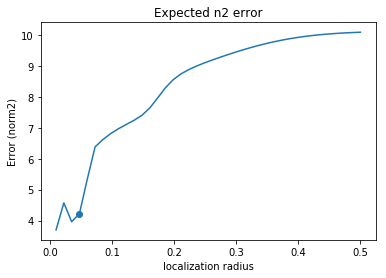

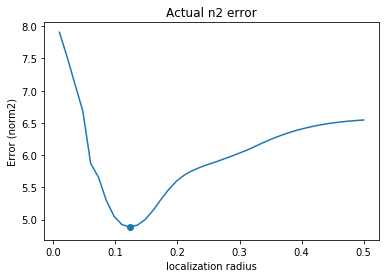

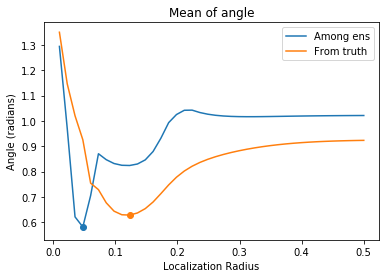

In [163]:
print(f'Ens size: {ens_size}', '\n')
print(f'Ens of ens size: {ens_ens_size}', '\n')
print(f'Number of singular values: {sig_num}', '\n')

ee2_arg = exp_error_n2[:-3].argmin()
this_rho = rho_array[ee2_arg]
print(f'Minimize expected norm2 error: {this_rho:0.4}')
print('(Sample mean of norm2 error from ensemble mean)', '\n')

e2_arg = error_n2.argmin()
this_rho = rho_array[e2_arg]
print(f'Minimize norm2 error: {this_rho:0.4}', '\n')

ea_arg = V_average_angle.argmin()
this_rho = rho_array[ea_arg]
print(f'Minimize average angle among ensembles: {this_rho:0.4}', '\n')

aa_arg = V_angle_truth2ens_mean.ravel().argmin()
this_rho = rho_array[aa_arg]
print(f'Minimize average angle from truth: {this_rho:0.4}', '\n')

plt.figure()
plt.plot(rho_array, exp_error_n2)
plt.scatter(rho_array[ee2_arg], exp_error_n2[ee2_arg])
plt.title('Expected n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')

plt.figure()
plt.plot(rho_array, error_n2)
plt.scatter(rho_array[e2_arg], error_n2[e2_arg])
plt.title('Actual n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')


plt.figure()
plt.plot(rho_array, V_average_angle)
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.scatter(rho_array[ea_arg],
            V_average_angle[ea_arg])
plt.scatter(rho_array[aa_arg],
            V_angle_truth2ens_mean.ravel()[aa_arg])
plt.legend(['Among ens', 'From truth'])
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle')

Ens size: 40 

Ens of ens size: 4 

Number of singular values: 3 

Minimize expected norm2 error: 0.1985
(Sample mean of norm2 error from ensemble mean) 

Minimize norm2 error: 0.2487 

Minimize average angle among ensembles: 0.2613 

Minimize average angle from truth: 0.2613 



Text(0.5,1,'Mean of angle')

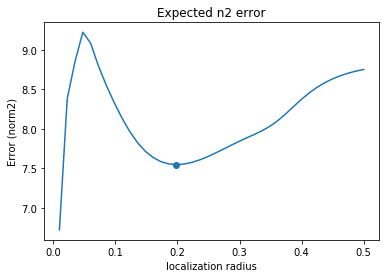

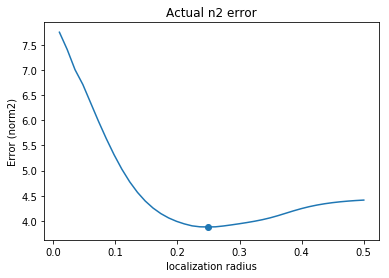

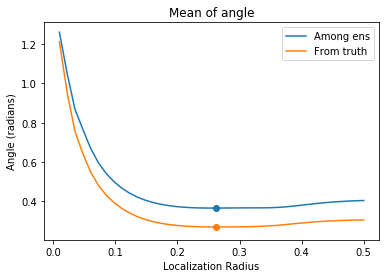

In [156]:
print(f'Ens size: {ens_size}', '\n')
print(f'Ens of ens size: {ens_ens_size}', '\n')
print(f'Number of singular values: {sig_num}', '\n')

ee2_arg = exp_error_n2[:-3].argmin()
this_rho = rho_array[ee2_arg]
print(f'Minimize expected norm2 error: {this_rho:0.4}')
print('(Sample mean of norm2 error from ensemble mean)', '\n')

e2_arg = error_n2.argmin()
this_rho = rho_array[e2_arg]
print(f'Minimize norm2 error: {this_rho:0.4}', '\n')

ea_arg = V_average_angle.argmin()
this_rho = rho_array[ea_arg]
print(f'Minimize average angle among ensembles: {this_rho:0.4}', '\n')

aa_arg = V_angle_truth2ens_mean.ravel().argmin()
this_rho = rho_array[aa_arg]
print(f'Minimize average angle from truth: {this_rho:0.4}', '\n')

plt.figure()
plt.plot(rho_array, exp_error_n2)
plt.scatter(rho_array[ee2_arg], exp_error_n2[ee2_arg])
plt.title('Expected n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')

plt.figure()
plt.plot(rho_array, error_n2)
plt.scatter(rho_array[e2_arg], error_n2[e2_arg])
plt.title('Actual n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')


plt.figure()
plt.plot(rho_array, V_average_angle)
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.scatter(rho_array[ea_arg],
            V_average_angle[ea_arg])
plt.scatter(rho_array[aa_arg],
            V_angle_truth2ens_mean.ravel()[aa_arg])
plt.legend(['Among ens', 'From truth'])
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle')

Ens size: 20 

Ens of ens size: 4 

Number of singular values: 3 

Minimize expected norm2 error: 0.1231
(Sample mean of norm2 error from ensemble mean) 

Minimize norm2 error: 0.1356 

Minimize average angle among ensembles: 0.1356 

Minimize average angle from truth: 0.1482 



Text(0.5,1,'Mean of angle')

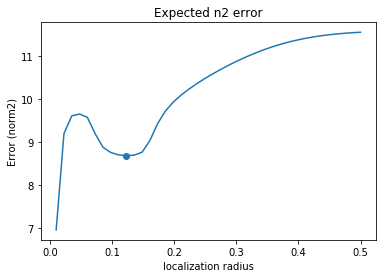

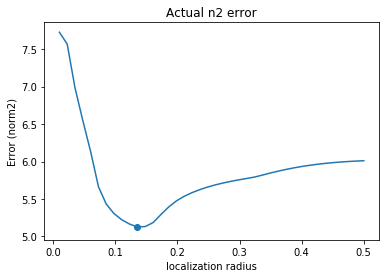

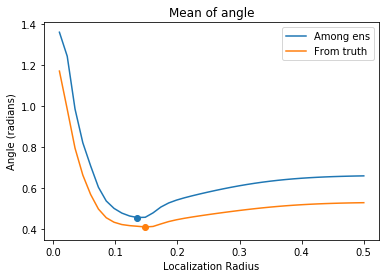

In [145]:
print(f'Ens size: {ens_size}', '\n')
print(f'Ens of ens size: {ens_ens_size}', '\n')
print(f'Number of singular values: {sig_num}', '\n')

ee2_arg = exp_error_n2[:-3].argmin()
this_rho = rho_array[ee2_arg]
print(f'Minimize expected norm2 error: {this_rho:0.4}')
print('(Sample mean of norm2 error from ensemble mean)', '\n')

e2_arg = error_n2.argmin()
this_rho = rho_array[e2_arg]
print(f'Minimize norm2 error: {this_rho:0.4}', '\n')

ea_arg = V_average_angle.argmin()
this_rho = rho_array[ea_arg]
print(f'Minimize average angle among ensembles: {this_rho:0.4}', '\n')

aa_arg = V_angle_truth2ens_mean.ravel().argmin()
this_rho = rho_array[aa_arg]
print(f'Minimize average angle from truth: {this_rho:0.4}', '\n')

plt.figure()
plt.plot(rho_array, exp_error_n2)
plt.scatter(rho_array[ee2_arg], exp_error_n2[ee2_arg])
plt.title('Expected n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')

plt.figure()
plt.plot(rho_array, error_n2)
plt.scatter(rho_array[e2_arg], error_n2[e2_arg])
plt.title('Actual n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')


plt.figure()
plt.plot(rho_array, V_average_angle)
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.scatter(rho_array[ea_arg],
            V_average_angle[ea_arg])
plt.scatter(rho_array[aa_arg],
            V_angle_truth2ens_mean.ravel()[aa_arg])
plt.legend(['Among ens', 'From truth'])
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle')

Ens size: 20 

Ens of ens size: 20 

Number of singular values: 3 

Minimize expected norm2 error: 0.1105
(Sample mean of norm2 error from ensemble mean) 

Minimize norm2 error: 0.1985 

Minimize average angle among ensembles: 0.1859 

Minimize average angle from truth: 0.1985 



Text(0.5,1,'Mean of angle')

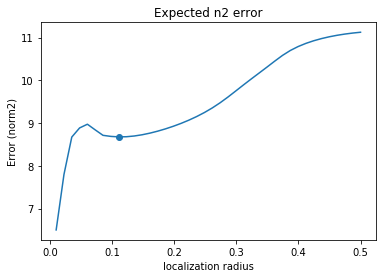

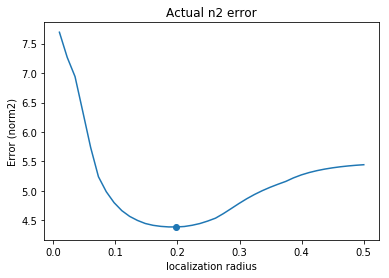

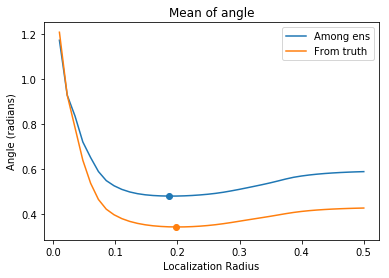

In [124]:
print(f'Ens size: {ens_size}', '\n')
print(f'Ens of ens size: {ens_ens_size}', '\n')
print(f'Number of singular values: {sig_num}', '\n')

ee2_arg = exp_error_n2[:-3].argmin()
this_rho = rho_array[ee2_arg]
print(f'Minimize expected norm2 error: {this_rho:0.4}')
print('(Sample mean of norm2 error from ensemble mean)', '\n')

e2_arg = error_n2.argmin()
this_rho = rho_array[e2_arg]
print(f'Minimize norm2 error: {this_rho:0.4}', '\n')

ea_arg = V_average_angle.argmin()
this_rho = rho_array[ea_arg]
print(f'Minimize average angle among ensembles: {this_rho:0.4}', '\n')

aa_arg = V_angle_truth2ens_mean.ravel().argmin()
this_rho = rho_array[aa_arg]
print(f'Minimize average angle from truth: {this_rho:0.4}', '\n')

plt.figure()
plt.plot(rho_array, exp_error_n2)
plt.scatter(rho_array[ee2_arg], exp_error_n2[ee2_arg])
plt.title('Expected n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')

plt.figure()
plt.plot(rho_array, error_n2)
plt.scatter(rho_array[e2_arg], error_n2[e2_arg])
plt.title('Actual n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')


plt.figure()
plt.plot(rho_array, V_average_angle)
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.scatter(rho_array[ea_arg],
            V_average_angle[ea_arg])
plt.scatter(rho_array[aa_arg],
            V_angle_truth2ens_mean.ravel()[aa_arg])
plt.legend(['Among ens', 'From truth'])
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle')

Ens size: 20 

Ens of ens size: 10 

Number of singular values: 3 

Minimize expected norm2 error: 0.1356
(Sample mean of norm2 error from ensemble mean) 

Minimize norm2 error: 0.1482 

Minimize average angle among ensembles: 0.1608 

Minimize average angle from truth: 0.1608 



Text(0.5,1,'Mean of angle')

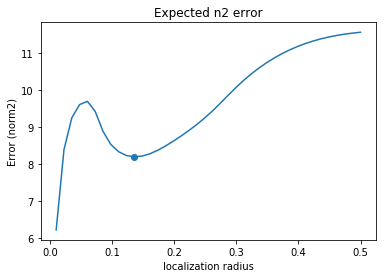

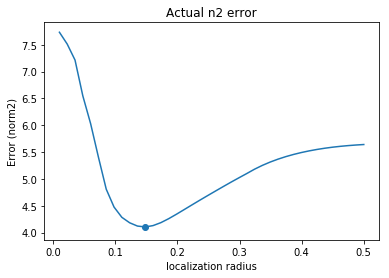

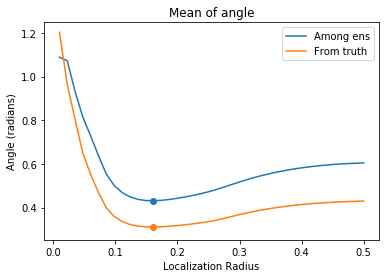

In [115]:
print(f'Ens size: {ens_size}', '\n')
print(f'Ens of ens size: {ens_ens_size}', '\n')
print(f'Number of singular values: {sig_num}', '\n')

ee2_arg = exp_error_n2[:-10].argmin()
this_rho = rho_array[ee2_arg]
print(f'Minimize expected norm2 error: {this_rho:0.4}')
print('(Sample mean of norm2 error from ensemble mean)', '\n')

e2_arg = error_n2.argmin()
this_rho = rho_array[e2_arg]
print(f'Minimize norm2 error: {this_rho:0.4}', '\n')

ea_arg = V_average_angle.argmin()
this_rho = rho_array[ea_arg]
print(f'Minimize average angle among ensembles: {this_rho:0.4}', '\n')

aa_arg = V_angle_truth2ens_mean.ravel().argmin()
this_rho = rho_array[aa_arg]
print(f'Minimize average angle from truth: {this_rho:0.4}', '\n')

plt.figure()
plt.plot(rho_array, exp_error_n2)
plt.scatter(rho_array[ee2_arg], exp_error_n2[ee2_arg])
plt.title('Expected n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')

plt.figure()
plt.plot(rho_array, error_n2)
plt.scatter(rho_array[e2_arg], error_n2[e2_arg])
plt.title('Actual n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')


plt.figure()
plt.plot(rho_array, V_average_angle)
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.scatter(rho_array[ea_arg],
            V_average_angle[ea_arg])
plt.scatter(rho_array[aa_arg],
            V_angle_truth2ens_mean.ravel()[aa_arg])
plt.legend(['Among ens', 'From truth'])
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle')

Ens size: 20 

Ens of ens size: 10 

Number of singular values: 5 

Minimize expected norm2 error: 0.1859
(Sample mean of norm2 error from ensemble mean) 

Minimize norm2 error: 0.1985 

Minimize average angle among ensembles: 0.211 

Minimize average angle from truth: 0.211 



Text(0.5,1,'Mean of angle')

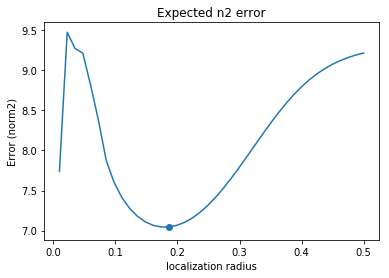

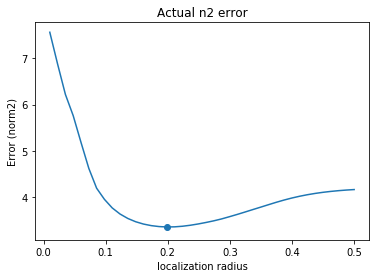

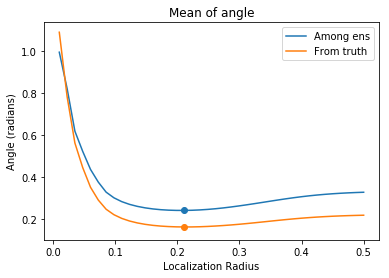

In [88]:
print(f'Ens size: {ens_size}', '\n')
print(f'Ens of ens size: {ens_ens_size}', '\n')
print(f'Number of singular values: {sig_num}', '\n')

ee2_arg = exp_error_n2.argmin()
this_rho = rho_array[ee2_arg]
print(f'Minimize expected norm2 error: {this_rho:0.4}')
print('(Sample mean of norm2 error from ensemble mean)', '\n')

e2_arg = error_n2.argmin()
this_rho = rho_array[e2_arg]
print(f'Minimize norm2 error: {this_rho:0.4}', '\n')

ea_arg = V_average_angle.argmin()
this_rho = rho_array[ea_arg]
print(f'Minimize average angle among ensembles: {this_rho:0.4}', '\n')

aa_arg = V_angle_truth2ens_mean.ravel().argmin()
this_rho = rho_array[aa_arg]
print(f'Minimize average angle from truth: {this_rho:0.4}', '\n')

plt.figure()
plt.plot(rho_array, exp_error_n2)
plt.scatter(rho_array[ee2_arg], exp_error_n2[ee2_arg])
plt.title('Expected n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')

plt.figure()
plt.plot(rho_array, error_n2)
plt.scatter(rho_array[e2_arg], error_n2[e2_arg])
plt.title('Actual n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')


plt.figure()
plt.plot(rho_array, V_average_angle)
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.scatter(rho_array[ea_arg],
            V_average_angle[ea_arg])
plt.scatter(rho_array[aa_arg],
            V_angle_truth2ens_mean.ravel()[aa_arg])
plt.legend(['Among ens', 'From truth'])
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle')

Ens size: 20 

Ens of ens size: 10 

Number of singular values: 9 

Minimize expected norm2 error: 0.09795
(Sample mean of norm2 error from ensemble mean) 

Minimize norm2 error: 0.1231 

Minimize average angle among ensembles: 0.1985 

Minimize average angle from truth: 0.1985 



Text(0.5,1,'Mean of angle')

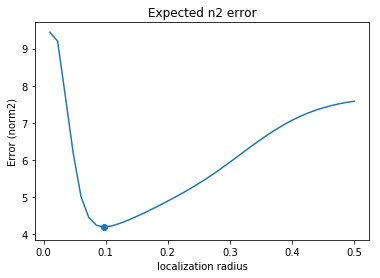

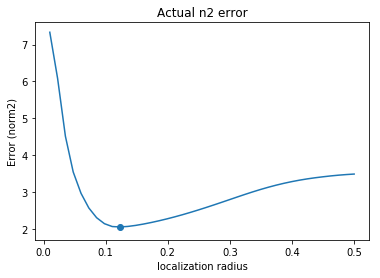

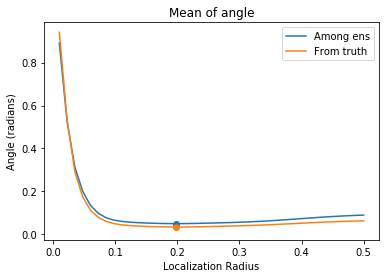

In [95]:
print(f'Ens size: {ens_size}', '\n')
print(f'Ens of ens size: {ens_ens_size}', '\n')
print(f'Number of singular values: {sig_num}', '\n')

ee2_arg = exp_error_n2.argmin()
this_rho = rho_array[ee2_arg]
print(f'Minimize expected norm2 error: {this_rho:0.4}')
print('(Sample mean of norm2 error from ensemble mean)', '\n')

e2_arg = error_n2.argmin()
this_rho = rho_array[e2_arg]
print(f'Minimize norm2 error: {this_rho:0.4}', '\n')

ea_arg = V_average_angle.argmin()
this_rho = rho_array[ea_arg]
print(f'Minimize average angle among ensembles: {this_rho:0.4}', '\n')

aa_arg = V_angle_truth2ens_mean.ravel().argmin()
this_rho = rho_array[aa_arg]
print(f'Minimize average angle from truth: {this_rho:0.4}', '\n')

plt.figure()
plt.plot(rho_array, exp_error_n2)
plt.scatter(rho_array[ee2_arg], exp_error_n2[ee2_arg])
plt.title('Expected n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')

plt.figure()
plt.plot(rho_array, error_n2)
plt.scatter(rho_array[e2_arg], error_n2[e2_arg])
plt.title('Actual n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')


plt.figure()
plt.plot(rho_array, V_average_angle)
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.scatter(rho_array[ea_arg],
            V_average_angle[ea_arg])
plt.scatter(rho_array[aa_arg],
            V_angle_truth2ens_mean.ravel()[aa_arg])
plt.legend(['Among ens', 'From truth'])
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle')

Ens size: 40 

Ens of ens size: 10 

Number of singular values: 5 

Minimize expected norm2 error: 0.1733
(Sample mean of norm2 error from ensemble mean) 

Minimize norm2 error: 0.1733 

Minimize average angle among ensembles: 0.2236 

Minimize average angle from truth: 0.2362 



Text(0.5,1,'Mean of angle')

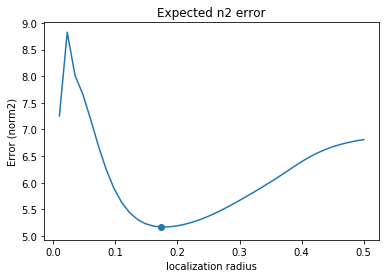

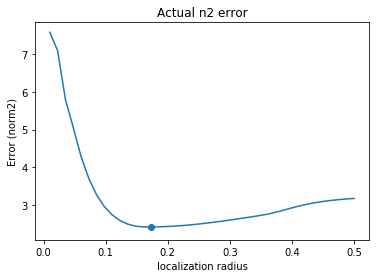

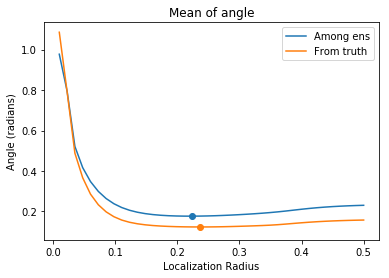

In [81]:
print(f'Ens size: {ens_size}', '\n')
print(f'Ens of ens size: {ens_ens_size}', '\n')
print(f'Number of singular values: {sig_num}', '\n')

ee2_arg = exp_error_n2.argmin()
this_rho = rho_array[ee2_arg]
print(f'Minimize expected norm2 error: {this_rho:0.4}')
print('(Sample mean of norm2 error from ensemble mean)', '\n')

e2_arg = error_n2.argmin()
this_rho = rho_array[e2_arg]
print(f'Minimize norm2 error: {this_rho:0.4}', '\n')

ea_arg = V_average_angle.argmin()
this_rho = rho_array[ea_arg]
print(f'Minimize average angle among ensembles: {this_rho:0.4}', '\n')

aa_arg = V_angle_truth2ens_mean.ravel().argmin()
this_rho = rho_array[aa_arg]
print(f'Minimize average angle from truth: {this_rho:0.4}', '\n')

plt.figure()
plt.plot(rho_array, exp_error_n2)
plt.scatter(rho_array[ee2_arg], exp_error_n2[ee2_arg])
plt.title('Expected n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')

plt.figure()
plt.plot(rho_array, error_n2)
plt.scatter(rho_array[e2_arg], error_n2[e2_arg])
plt.title('Actual n2 error')
plt.ylabel('Error (norm2)')
plt.xlabel('localization radius')


plt.figure()
plt.plot(rho_array, V_average_angle)
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.scatter(rho_array[ea_arg],
            V_average_angle[ea_arg])
plt.scatter(rho_array[aa_arg],
            V_angle_truth2ens_mean.ravel()[aa_arg])
plt.legend(['Among ens', 'From truth'])
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle')

In [5]:
# dimension = 2**9
# print(dimension)
# rho0 = 0.1
# # dx = 0.25
# dx = 1/dimension

# obs_size = int(dimension/2)
# H = assimilate.random_H(dimension, obs_size)

# # H = np.eye(dimension)[::2]

# rho = np.arange(dimension, dtype=float)
# rho = np.minimum(rho, (dimension - rho) % dimension)
# rho = rho*dx

In [6]:
# eig_val, eig_vec, P, sort_ind = covariance.generate_circulant(
#     dimension, dx, rho0, covariance.fft_sqd_exp_1d,
#     return_Corr=True,
#     return_sort_ind=True)
# eig_val = eig_val * (eig_val.size/eig_val.sum())
# eig_vec = eig_vec.real + eig_vec.imag
# # sort_ind = np.argsort(sort_ind)
# # eig_val = eig_val[sort_ind]
# # eig_vec = eig_vec[:, sort_ind]
# # eig_val = np.fft.fftshift(eig_val)
# # eig_vec = np.fft.fftshift(eig_vec, axes=1)

# P = eig_vec @ np.diag(eig_val) @ eig_vec.conj().T
# P = P.real

# R = np.eye(obs_size)

In [7]:
# imshow(P, vmin=0)
# imshow(H)

In [8]:
# trans_mats = assimilate.transformation_matrices(
#     H, eig_val_p=eig_val, eig_vec_p=eig_vec,
#     R=R, return_Ts=True)

# for key, val in trans_mats.items():
#     exec(key + '=val')

In [9]:
# imshow(U @ S @ VT)
# imshow(H @ P_sqrt)

# imshow((H @ P_sqrt).T @ (H @ P_sqrt))

# imshow((H @ P_sqrt) @ (H @ P_sqrt).T)

In [10]:
# prev = np.zeros_like(S)
# for ii in range(21):
#     plt.figure()
#     plt.plot(U[:, ii])
#     plt.title(f'U[:, {ii}]')
    
#     plt.figure()
#     plt.plot(VT[ii])
#     plt.title(f'VT[:, {ii}]')
    
#     prev += (S.diagonal()[ii]
#              * U[:, ii:ii+1]
#              @ VT[ii:ii + 1])
    
#     imshow(prev, f'Reconstruction: <={ii}')

In [11]:
# ens_size = 30
# mu = np.zeros(dimension)

In [12]:
# ensemble = assimilate.generate_ensemble(
#     ens_size, mu, trans_mats['P_sqrt'])

In [13]:
# rho_loc = 0.2
# [loc] = covariance.generate_circulant(
#     dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
#     return_Corr=True, return_eig=False)
# loc /= loc.max()
# P_sample = np.cov(ensemble)
# vmin = P_sample.min()
# vmax = np.max([P_sample.max(), 1])
# imshow(P_sample,
#        vmin=vmin, vmax=vmax,
#        title=f'No loc: {ens_size}')

# imshow(loc,
#        title=f'loc')
# imshow(P_sample * loc,
#        vmin=vmin, vmax=vmax,
#        title=f'With loc: {ens_size}')
# imshow(P,
#        vmin=vmin, vmax=vmax,
#        title=f'True')

In [14]:
# trans_mats_sample = assimilate.transformation_matrices(
#         H, P=P_sample,
#         R=R, return_Ts=True)
# U_sample = trans_mats_sample['U']
# S_sample = trans_mats_sample['S']
# VT_sample = trans_mats_sample['VT']

In [15]:
# sig_num = 5
# reduced_true = U[:, :sig_num] @ S[:sig_num, :sig_num] @ VT[:sig_num]
# # imshow(reduced_true, f'Reduced true; sig_num: {sig_num}')
# rho_array = np.linspace(.31, 0.01, 20)
# rmse = np.ones_like(rho_array) * np.nan
# first_singular = rmse.copy()
# for count, rho_loc in enumerate(rho_array):
#     [loc] = covariance.generate_circulant(
#         dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
#         return_Corr=True, return_eig=False)
#     loc /= loc.max() 
#     P_loc = P_sample * loc
# #     imshow(P_loc, f'P_loc: {rho_loc:0.3}')
#     this_trans_mats = assimilate.transformation_matrices(
#         H, P=P_loc,
#         R=R, return_Ts=True)
#     aU = this_trans_mats['U']
#     aS = this_trans_mats['S']
#     aVT = this_trans_mats['VT']
#     first_singular[count] = aS[0,0]
#     this_reduced = (aU[:, :sig_num]
#                     @ aS[:sig_num, :sig_num]
#                     @ aVT[:sig_num])
# #     imshow(this_reduced, f'Reduced sample; rho: {rho_loc:0.3}')
#     error = this_reduced - reduced_true
#     rmse[count] = (error ** 2).mean()
# #     imshow(error, f'Error; rmse: {rmse[count]:0.4}')
    
# plt.figure()
# plt.plot(rho_array, rmse)
# plt.ylabel('RMSE of construction')
# plt.xlabel('localization radius')


# plt.figure()
# plt.plot(rho_array, first_singular)
# plt.ylabel('First singular value')
# plt.xlabel('localization radius')

In [16]:
# min_index = rmse.argmin()
# rho_min = rho_array[min_index]

# rho_loc = rho_min
# [loc] = covariance.generate_circulant(
#     dimension, dx, rho_loc, covariance.fft_sqd_exp_1d,
#     return_Corr=True, return_eig=False)
# loc /= loc.max() 
# P_loc = P_sample * loc
# imshow(P, f'True P')
# imshow(P_sample, 'P_sample')
# imshow(P_loc, f'P_loc: {rho_loc:0.3}')

# this_trans_mats = assimilate.transformation_matrices(
#     H, P=P_loc,
#     R=R, return_Ts=True)
# aU = this_trans_mats['U']
# aS = this_trans_mats['S']
# aVT = this_trans_mats['VT']
# this_reduced = (aU[:, :sig_num]
#                 @ aS[:sig_num, :sig_num]
#                 @ aVT[:sig_num])
# imshow(reduced_true, f'Reduced true; sig_num: {sig_num}')
# imshow(this_reduced, f'Reduced sample; rho: {rho_loc:0.3}')
# imshow(this_reduced, f'Reduced sample; rho: {rho_loc:0.3}',
#        vmin=reduced_true.min(), vmax=reduced_true.max())
# error = this_reduced - reduced_true
# rmse[count] = (error ** 2).mean()
# imshow(error, f'Error; rmse: {rmse[count]:0.4}')

# full = (aU @ aS @ aVT)
# full_sample = (U_sample @ S_sample @ VT_sample)
# imshow(H @ P_sqrt, f'Full true')
# imshow(full_sample, f'Full sample')
# imshow(full, f'Full sample loc')

In [31]:
# # vmax = reduced_var.max()
# vmax = None
# for rho_count in range(rho_array.size):
#     imshow(reduced_var[:, :, rho_count],
#            f'Variance for rho: {rho_array[rho_count]:0.4}',
#            vmin=0, vmax=vmax)

In [32]:
# plt.figure()
# plt.plot(rho_array, P_var.mean(axis=(0, 1)))
# plt.title('Average variance of P among ensembles')
# plt.ylabel('Variance')
# plt.xlabel('localization radius')

# plt.figure()
# plt.plot(rho_array, P_sqrt_var.mean(axis=(0, 1)))
# plt.title('Average variance of P_sqrt among ensembles')
# plt.ylabel('Variance')
# plt.xlabel('localization radius')

# vmax = P_var.max()
# for rho_count in range(rho_array.size):
#     imshow(P_var[:, :, rho_count],
#            f'Variance of P for rho: {rho_array[rho_count]:0.4}',
#            vmin=0, vmax=vmax)

In [33]:
# vmax = P_var.max()
# for rho_count in range(rho_array.size):
#     imshow(P_var[:, :, rho_count],
#            f'Variance of P for rho: {rho_array[rho_count]:0.4}',
#            vmin=0, vmax=vmax)

In [34]:
# vmax = None
# for rho_count in range(rho_array.size):
#     imshow(P_sqrt_var[:, :, rho_count],
#            f'Variance of P_sqrt rho: {rho_array[rho_count]:0.4}',
#            vmin=0, vmax=vmax)

In [36]:
# true_V = VT[:sig_num].T
# sample_mean_V = V_array.mean(axis=-1)
# V_angle_truth2ens = np.ones(
#     [1, rho_array.size, ens_ens_size]) * np.nan
# for rho_count in range(rho_array.size):
#     for ens_count in range(ens_ens_size):
#         aV = V_array[:, :, rho_count, ens_count]
#         V_dist = angle(aV, true_V)
#         V_angle_truth2ens[0, rho_count, ens_count] = V_dist
# V_angle_truth2ens_var = V_angle_truth2ens.var(axis=-1)
# V_angle_truth2ens_mean = V_angle_truth2ens.mean(axis=-1)

In [41]:
# import math
# true_V = VT[:sig_num].T
# sample_mean_V = V_array.mean(axis=-1)
# comb_num = round(
#     math.factorial(ens_ens_size)
#     / (math.factorial(2) 
#        * math.factorial(ens_ens_size - 2)))
# V_average_angle = np.ones(
#     rho_array.size) * np.nan
# V_variance_angle = V_average_angle.copy()
# for rho_count in range(rho_array.size):
#     angle_count = 0
#     angles = np.ones(comb_num) * np.nan
#     for ens_count in range(ens_ens_size):
#         aV = V_array[:, :, rho_count, ens_count]
#         for other_ens_count in range(ens_count + 1, ens_ens_size):
#             oV = V_array[:, :, rho_count, other_ens_count]
#             V_dist = angle_2(aV, oV)
#             angles[angle_count] = V_dist
#             angle_count += 1
#     V_average_angle[rho_count] = angles.mean()
#     V_variance_angle[rho_count] = angles.var()

In [77]:
true_V = VT[:sig_num].T
sample_mean_V = V_array.mean(axis=-1)
V_angle_truth2ens = np.ones(
    [1, rho_array.size, ens_ens_size]) * np.nan
V_angle_mean2ens = np.ones(
    [1, rho_array.size, ens_ens_size]) * np.nan
V_angle_truth2mean = np.ones(
    [1, rho_array.size]) * np.nan
for rho_count in range(rho_array.size):
    V_dist = angle_2(sample_mean_V[:, :, rho_count],
                   true_V)
    V_angle_truth2mean[0, rho_count] = V_dist
    for ens_count in range(ens_ens_size):
        aV = V_array[:, :, rho_count, ens_count]
        V_dist = angle_2(aV, true_V)
        V_angle_truth2ens[0, rho_count, ens_count] = V_dist
        
        V_dist = angle_2(aV, sample_mean_V[:, :,  rho_count])
        V_angle_mean2ens[0, rho_count, ens_count] = V_dist
V_angle_truth2ens_var = V_angle_truth2ens.var(axis=-1)
V_angle_truth2ens_mean = V_angle_truth2ens.mean(axis=-1)
V_angle_mean2ens_var = V_angle_mean2ens.var(axis=-1)
V_angle_mean2ens_mean = V_angle_mean2ens.mean(axis=-1)

[[ 0.79016261  0.60104197 -0.09357006  0.06149504 -0.03348345]
 [ 0.94108807  0.0837746   0.08168386  0.1831622  -0.25628604]
 [-0.06214146  0.16501347  0.9571188  -0.13085289  0.02085661]
 [-0.00378032  0.12689936 -0.26048406 -0.01366161 -0.88979134]
 [ 0.23083208  0.08444291  0.10231581  0.16446405 -0.85396327]]
[[ 0.24827909  0.8267327  -0.48471165  0.02695683  0.09015788]
 [ 0.88547964 -0.0579722   0.39391046  0.08851244  0.21343097]
 [-0.31185986  0.51855285  0.73721966 -0.14066063  0.11146466]
 [ 0.19247823  0.13646713  0.12171371 -0.1305246  -0.94138446]
 [ 0.12410216 -0.11393342 -0.12498096 -0.91745987  0.06743868]]
[[ 0.73488047  0.24806905 -0.33549805  0.12108353  0.04322939]
 [ 0.62605918  0.82163919  0.3071274  -0.29446761  0.07070579]
 [-0.01567118 -0.24385716  0.86716564 -0.17061762 -0.0374605 ]
 [ 0.24865126  0.41817538  0.09941358  0.85185988  0.78887828]
 [-0.02095034 -0.08565003  0.03568414 -0.04616975 -0.08120702]]
[[ 0.94937865  0.21481073  0.19124037 -0.10924208 -0

/anaconda3/envs/loc/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in arccos


Text(0.5,1,'Mean of angle from mean')

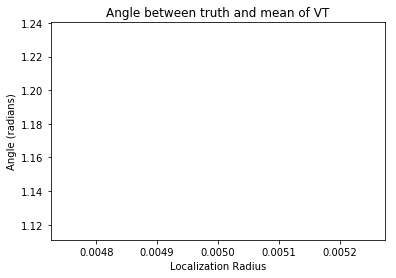

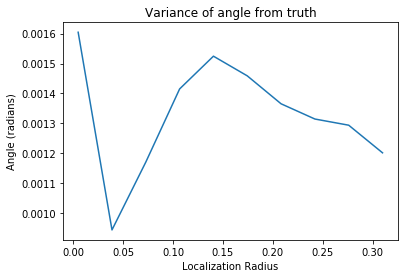

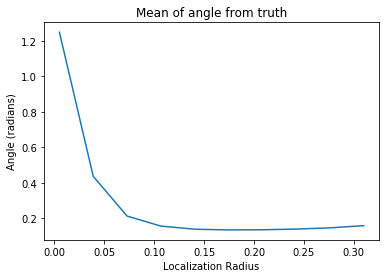

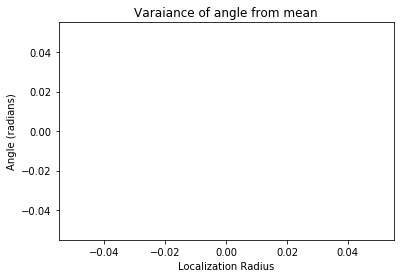

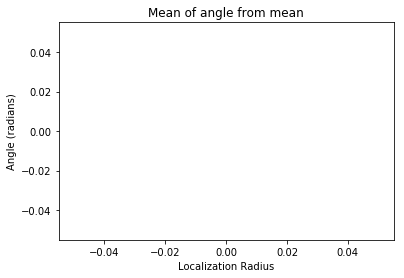

In [78]:
plt.figure()
plt.plot(rho_array, V_angle_truth2mean.ravel())
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Angle between truth and mean of VT')

plt.figure()
plt.plot(rho_array, V_angle_truth2ens_var.ravel())
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Variance of angle from truth')

plt.figure()
plt.plot(rho_array, V_angle_truth2ens_mean.ravel())
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle from truth')

plt.figure()
plt.plot(rho_array, V_angle_mean2ens_var.ravel())
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Varaiance of angle from mean')

plt.figure()
plt.plot(rho_array, V_angle_mean2ens_mean.ravel())
plt.xlabel('Localization Radius')
plt.ylabel('Angle (radians)')
plt.title('Mean of angle from mean')

In [37]:
this_V0 = np.eye(5)
this_V0 = this_V0[:, 1:]
this_V1 = np.eye(5)
this_V1 =  this_V1[:, 1:] + this_V1[:, :1]
print('V0: \n', this_V0, '\n')
print('V1: \n', this_V1, '\n')
print(angle(this_V0, this_V1))

V0: 
 [[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 

V1: 
 [[1. 1. 1. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 

0.7853981633974484


In [329]:
this_V0 = np.eye(5)
this_V0 = this_V0[:, 1:]
this_V1 = np.eye(5)
this_V1 =  this_V1[:, 1:] + this_V1[:, :1]
print('V0: \n', this_V0, '\n')
print('V1: \n', this_V1, '\n')
print(angle(this_V0, this_V1))

V0: 
 [[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 

V1: 
 [[1. 1. 1. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 

[0.70710678 0.70710678 0.70710678 0.70710678]
0.7853981633974484


/Users/harty/anaconda3/envs/multiloc/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


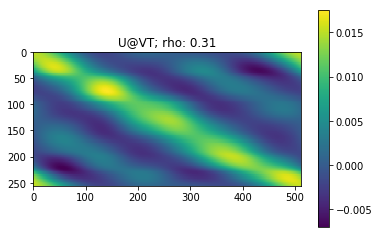

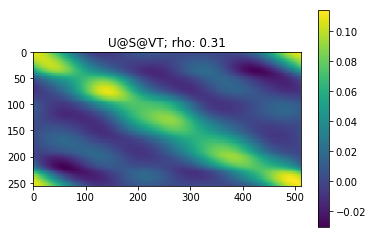

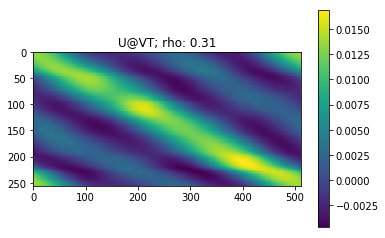

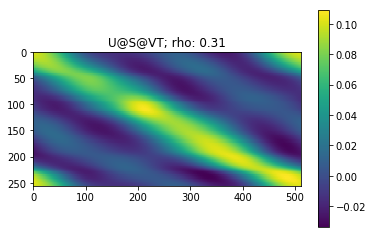

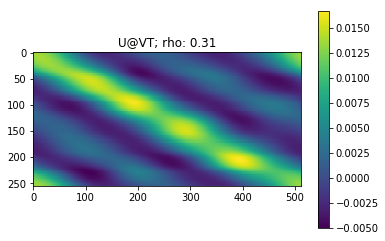

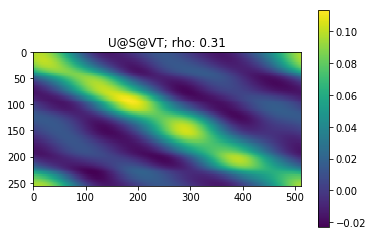

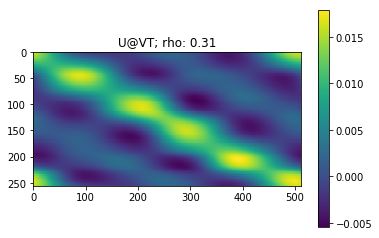

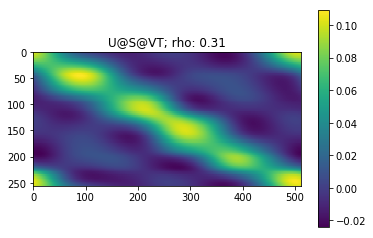

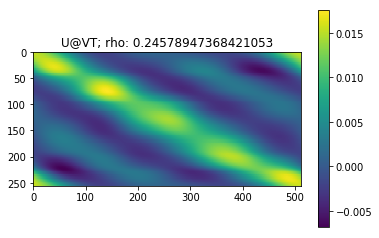

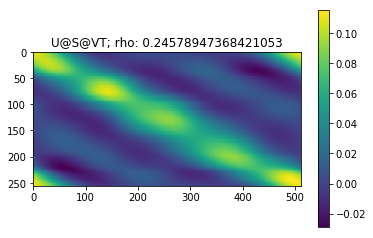

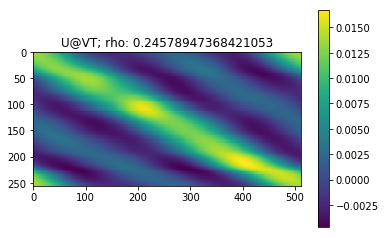

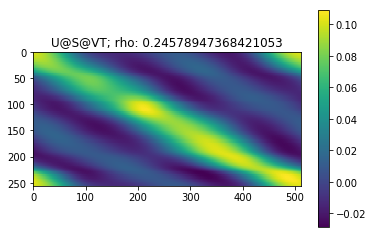

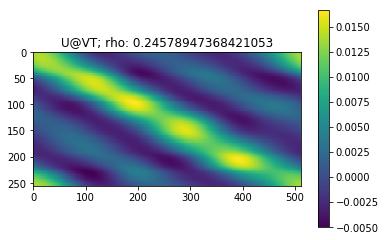

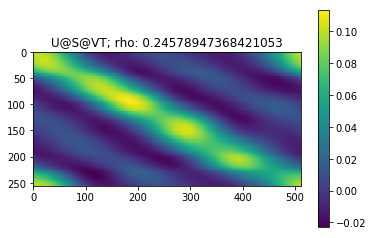

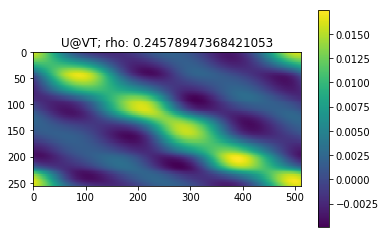

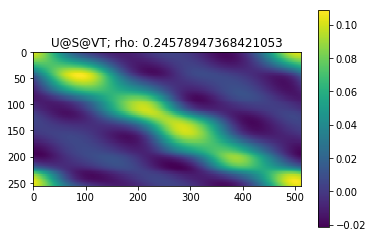

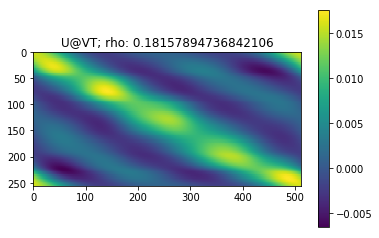

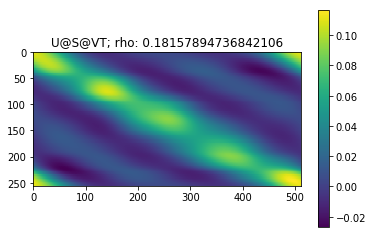

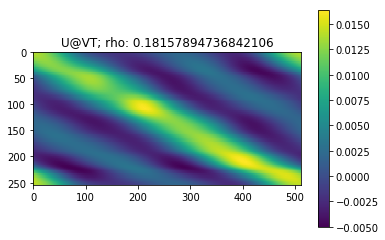

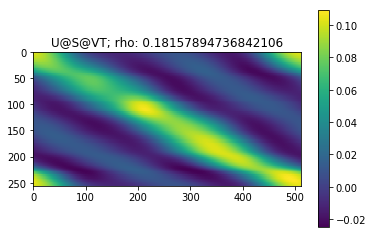

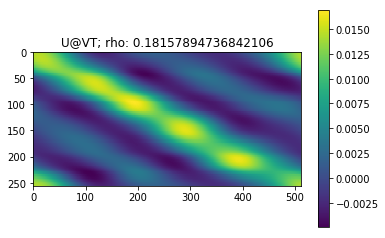

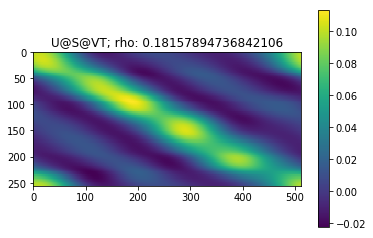

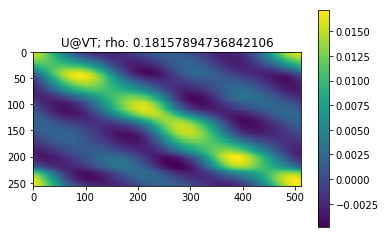

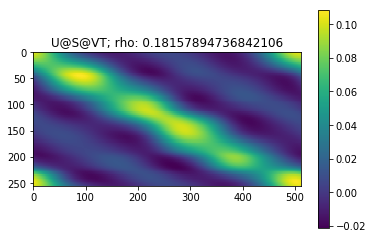

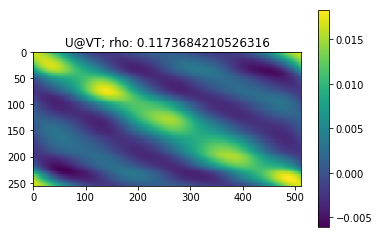

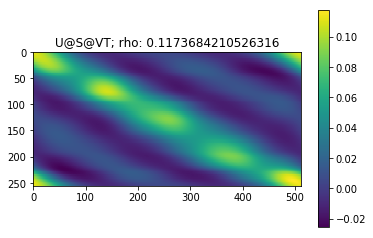

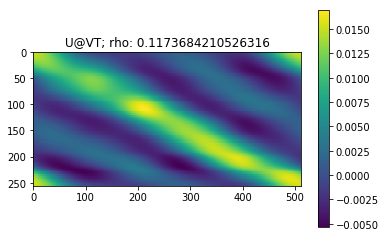

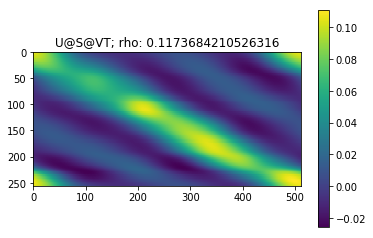

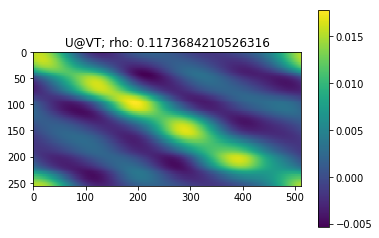

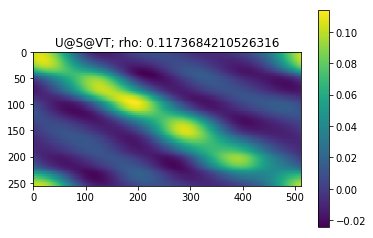

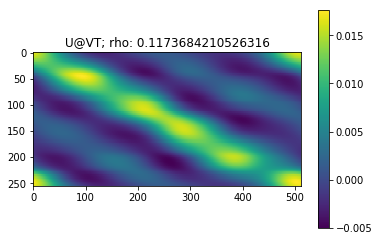

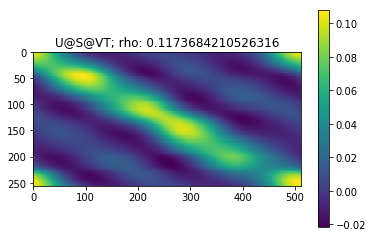

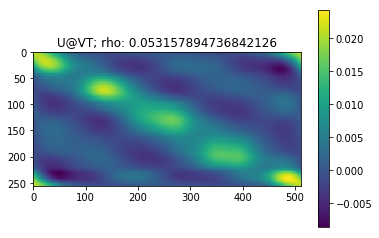

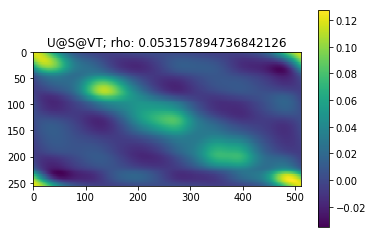

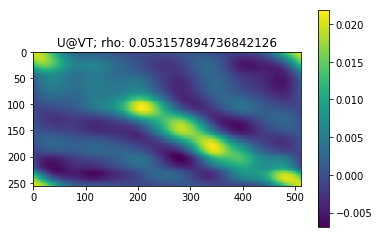

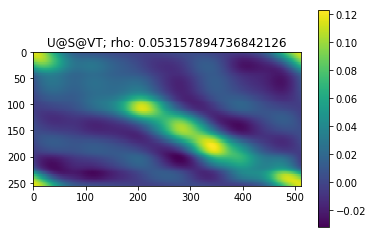

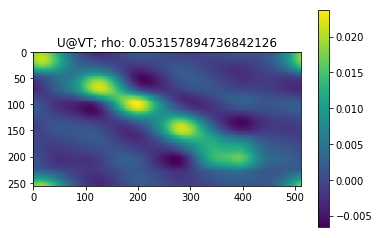

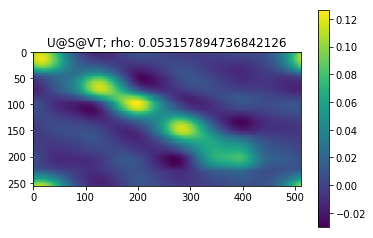

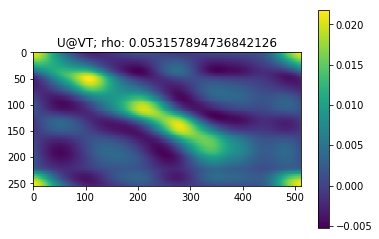

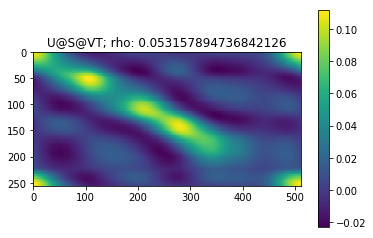

In [285]:
this_sig_num = 5
for rho_count in np.arange(rho_array.size)[::4]:
    for ens_count in range(4):
        aV = V_array[:, :this_sig_num, rho_count, ens_count]
        aU = U_array[:, :this_sig_num, rho_count, ens_count]
        aS = s_array[:this_sig_num, rho_count, ens_count]
        aS = np.diag(aS)
#         aS = np.concatenate(
#             [aS, np.zeros([obs_size - this_sig_num, this_sig_num])],
#             axis=0)
        imshow(aU @ aV.T,
               f'U@VT; rho: {rho_array[rho_count]}')
        imshow(aU @ aS @ aV.T,
               f'U@S@VT; rho: {rho_array[rho_count]}')

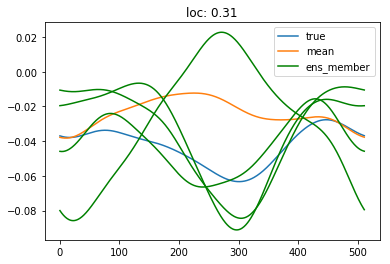

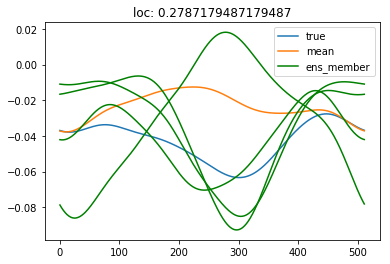

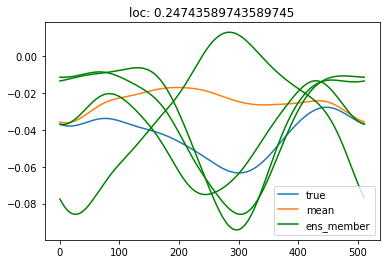

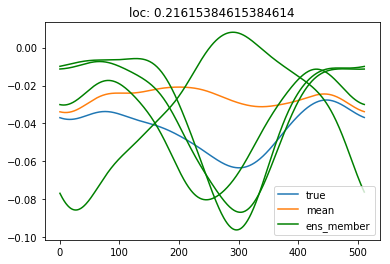

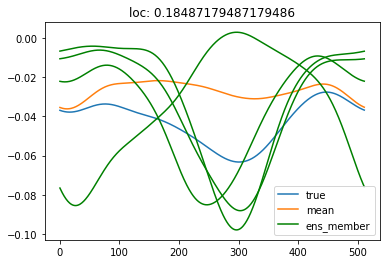

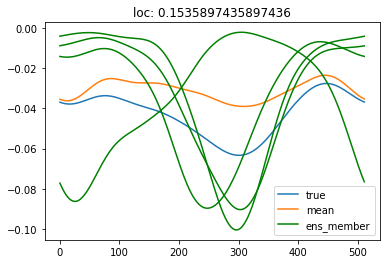

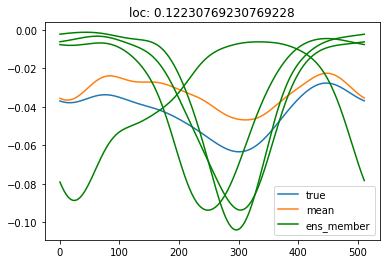

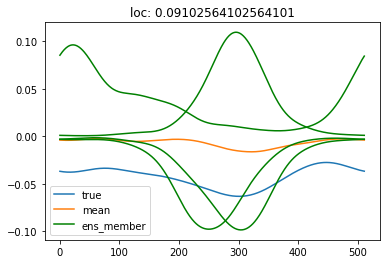

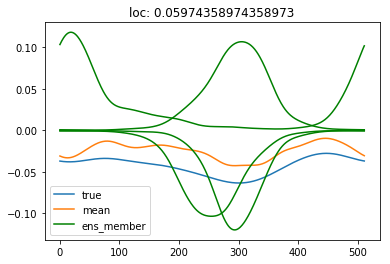

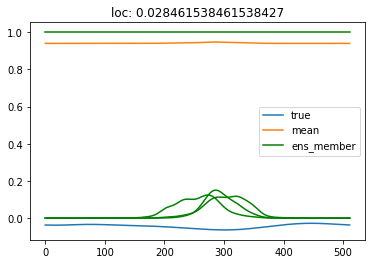

In [260]:
ens_plot_num = 4
for ii in np.arange(rho_array.size)[::4]:
    plt.figure()
    plt.plot(true_V[:, 0])
    plt.plot(sample_mean_V[:, 0, ii])
    for ens_mem in range(ens_plot_num):
        plt.plot(V_array[:, 0, ii, ens_mem], 'g')
    plt.legend(['true', 'mean', 'ens_member'])
    plt.title(f'loc: {rho_array[ii]}')

In [142]:
def angle_1d(v0, v1):
    dist = v0 @ v1
    dist = dist/(
        np.linalg.norm(v0)
        * np.linalg.norm(v1))
    dist = np.arccos(dist)
    return dist

In [160]:
# for only first singular vector
true_v = VT[0]
sample_mean_v = V_array.mean(axis=-1)
v_angle_truth2ens = np.ones(
    [1, rho_array.size, ens_ens_size])
v_angle_mean2ens = np.ones(
    [1, rho_array.size, ens_ens_size])
v_angle_truth2mean = np.ones(
    [1, rho_array.size])
for rho_count in range(rho_array.size):
    v_dist = angle_1d(sample_mean_v[:, rho_count],
                      true_v)
    v_angle_truth2mean[0, rho_count] = v_dist
    for ens_count in range(ens_ens_size):
        av = V_array[:, rho_count, ens_count]
        v_dist = angle_1d(av, true_v)
        v_angle_truth2ens[0, rho_count, ens_count] = v_dist
        
        v_dist = angle_1d(av, sample_mean_v[:, rho_count])
        v_angle_mean2ens[0, rho_count, ens_count] = v_dist
v_angle_truth2ens_var = v_angle_truth2ens.var(axis=-1)
v_angle_truth2ens_mean = v_angle_truth2ens.mean(axis=-1)
v_angle_mean2ens_var = v_angle_mean2ens.var(axis=-1)
v_angle_mean2ens_mean = v_angle_mean2ens.mean(axis=-1)

ValueError: shapes (512,2) and (3,512) not aligned: 2 (dim 1) != 3 (dim 0)

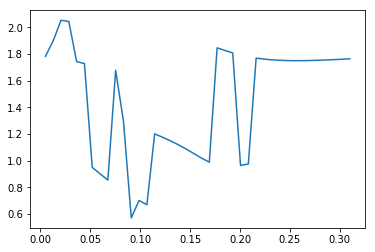

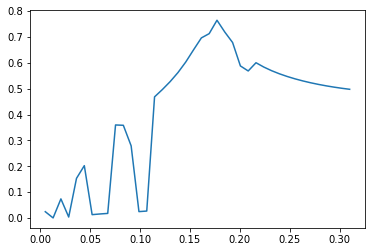

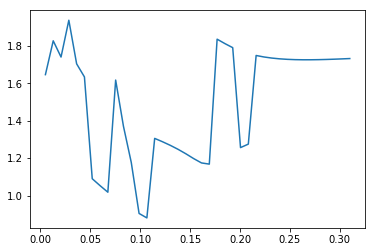

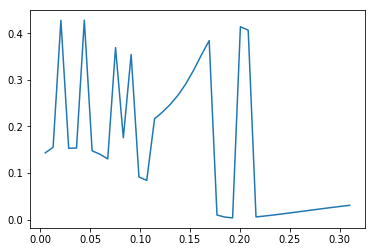

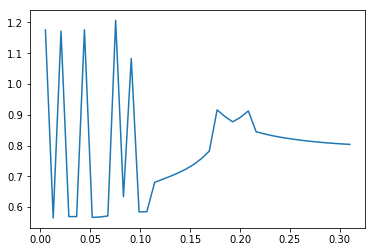

In [151]:
plt.figure()
plt.plot(rho_array, v_angle_truth2mean.ravel())

plt.figure()
plt.plot(rho_array, v_angle_truth2ens_var.ravel())

plt.figure()
plt.plot(rho_array, v_angle_truth2ens_mean.ravel())

plt.figure()
plt.plot(rho_array, v_angle_mean2ens_var.ravel())

plt.figure()
plt.plot(rho_array, v_angle_mean2ens_mean.ravel())
